# Classification of pure fortis, scandens, fuliginosa samples based on the morphological measures

* Data source: Introgressive hybridization and natural selection in Darwin's finches. Grant PR, Grant BR.  
https://datadryad.org/resource/doi:10.5061/dryad.vc348  
* Data Published:  November 11, 2015  
* Data shape: 2104 examples and 15 features
* Aim: Find the species/breed limits for fortis, scandens, fuliginosa  
* This is an expansion project after a failed separation of hybrids from pure breeds  
* Previous project: https://github.com/Fan-Han/Scikit_learn_prediction/blob/master/Hybrid_fortis_scandens.ipynb

In [ ]:
### Basic modules
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Import the data

In [3]:
# read the data
data0 = pd.read_csv("Dataset/fortis_scandens.txt", header = 0, sep = "\t")
data0.head()

,band,Species,sex,Time period,year,Early v Late,weight,wing,tarsus,bill length,bill depth,bill width,PC1 body,PC1 beak,PC2 beak
0,2639,fortis,male,1,1981,Early,15.84,67.13,19.55,10.30,8.95,8.32,-0.276196,-0.562615,-0.559996
1,2743,fortis,male,1,1981,Early,19.25,72.38,19.38,12.10,10.85,10.13,1.360188,3.103452,-1.217390
2,3527,fortis,male,1,1981,Early,17.27,71.12,19.60,11.79,10.33,9.59,0.792701,2.110300,-0.915424
3,4190,fortis,female,1,1981,Early,15.78,66.62,19.10,11.04,9.93,8.94,-0.613596,0.976308,-0.849961
4,4378,fortis,male,1,1981,Early,17.62,68.78,19.10,10.64,9.66,8.76,0.196324,0.487143,-0.873340


In [4]:
# Have an overview of the data
data0.describe()

,band,Time period,year,weight,wing,tarsus,bill length,bill depth,bill width,PC1 body,PC1 beak,PC2 beak
count,2105.000000,2105.000000,2105.000000,2105.000000,2103.000000,2105.000000,2105.000000,2104.000000,2105.000000,2103.000000,2104.000000,2104.000000
mean,17694.665558,3.857007,1999.158195,16.605230,67.986396,19.439732,11.515373,8.955010,8.533454,-0.004500,-0.006253,0.001259
std,3166.473254,1.754131,8.976583,2.535702,3.196140,1.102704,1.609500,0.812021,0.645526,1.579038,1.466034,0.808244
min,1444.000000,1.000000,1981.000000,8.300000,55.000000,15.500000,7.800000,6.000000,5.900000,-5.756511,-5.684106,-1.862806
25%,16143.000000,2.000000,1992.000000,14.800000,66.000000,18.700000,10.300000,8.500000,8.100000,-1.065584,-0.875650,-0.592867
50%,19017.000000,4.000000,2001.000000,16.400000,68.000000,19.300000,11.100000,9.000000,8.600000,-0.180165,0.076987,-0.258863
75%,19605.000000,6.000000,2009.000000,18.300000,70.000000,20.100000,12.810000,9.500000,8.900000,0.968344,0.951339,0.612926
max,22000.000000,6.000000,2012.000000,24.700000,80.000000,23.200000,16.000000,13.100000,11.400000,5.123422,6.462476,2.312322


In [5]:
# Number of empty values
data0.isna().sum()

band            0
Species         0
sex             0
Time period     0
year            0
Early v Late    0
weight          0
wing            2
tarsus          0
bill length     0
bill depth      1
bill width      0
PC1 body        2
PC1 beak        1
PC2 beak        1
dtype: int64

Apparently, very few rows have missing values which means we would not lose much data if we drop these examples. Band is only the identifier which is not useful, so we can also remove that column.

In [28]:
# Clean data
data1 = data0.copy()
data1 = data1.dropna().drop("band", axis = 1)

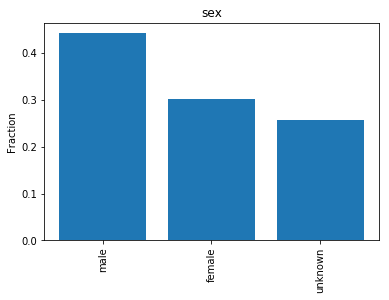

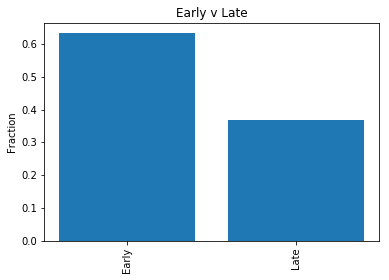

In [29]:
# Check for categorical columns
cat_features = ["sex", "Early v Late"]

def check_cat_features(data1, cat_features):
    for f in cat_features:
        counts = pd.DataFrame(data1[f].value_counts())
        counts["Fraction"] = counts[f]/counts[f].sum()
        plt.bar(counts.index, counts["Fraction"])
        plt.title(f)
        plt.ylabel("Fraction")
        plt.xticks(rotation = 90)
        plt.show()

check_cat_features(data1, cat_features)

Since Early v Late and Time period are another representations of year, we choose to use only year.  
Because the last three PC columns are reduced dimensions of weight, wing, and bill features, it may lose part of the variance. Therefore, we use the "direct" features.

In [30]:
data1 = data1.drop(["Early v Late", "Time period", "PC1 body", "PC1 beak", "PC2 beak"], axis = 1)

Because we only focus on the "pure breeds", we can drop the hybrids.

In [31]:
data1 = data1[~data1["Species"].isin(["fuliginosa-fortis", "scandens-fortis", "fortis-scandens"])]

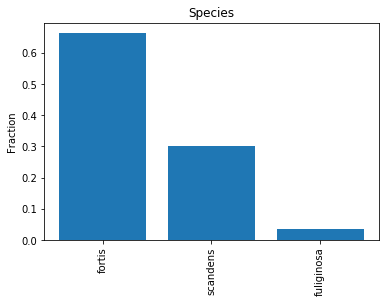

In [32]:
# Check the representation of the labels
label = ["Species"]
check_cat_features(data1, label)

As far as we can tell, about 25% of the examples have unknown sex. It will introduce bias if we use typical ways of imputation because sex is theoretically associated with other phenotypes. So the best way here is to keep unknow as an independent category.  

Another feature in this data is that we have stratified classes. This means it is necessary to draw proportionally samples from each class in training and test sets.

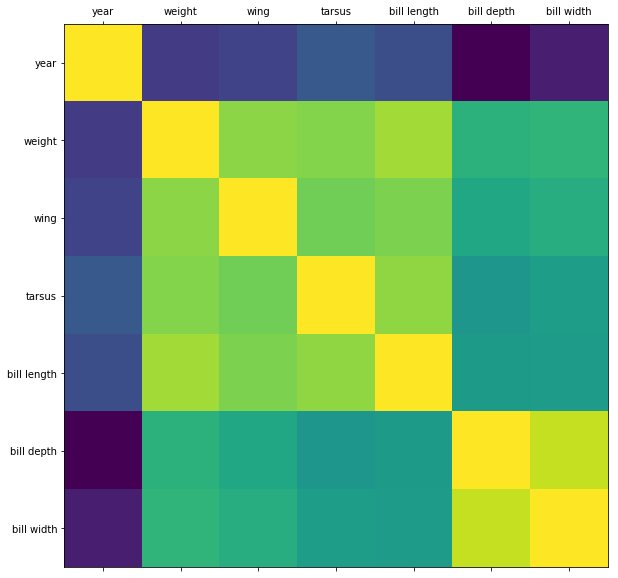

                 year    weight      wing    tarsus  bill length  bill depth  \
year         1.000000 -0.048645 -0.018735  0.083209     0.034463   -0.274071   
weight      -0.048645  1.000000  0.776850  0.765780     0.823030    0.547066   
wing        -0.018735  0.776850  1.000000  0.725747     0.747711    0.484774   
tarsus       0.083209  0.765780  0.725747  1.000000     0.786726    0.395857   
bill length  0.034463  0.823030  0.747711  0.786726     1.000000    0.422071   
bill depth  -0.274071  0.547066  0.484774  0.395857     0.422071    1.000000   
bill width  -0.169184  0.559887  0.519405  0.433961     0.428461    0.889501   

             bill width  
year          -0.169184  
weight         0.559887  
wing           0.519405  
tarsus         0.433961  
bill length    0.428461  
bill depth     0.889501  
bill width     1.000000  


In [33]:
# Further explore the feature correlations
feature_corr = data1.corr()
def corr_fig(feature_corr):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(feature_corr)
    ax.set_xticklabels([''] + ['year', 'weight', 'wing', 'tarsus', 'bill length',
       'bill depth', 'bill width'])
    ax.set_yticklabels([''] + ['year', 'weight', 'wing', 'tarsus', 'bill length',
       'bill depth', 'bill width'])
    plt.show()
corr_fig(feature_corr)
print(feature_corr)

Feature correlation shows bill depth and bill width are highly correlated.  
Weight is in general well correlated with other morphological measurements, especially bill length.

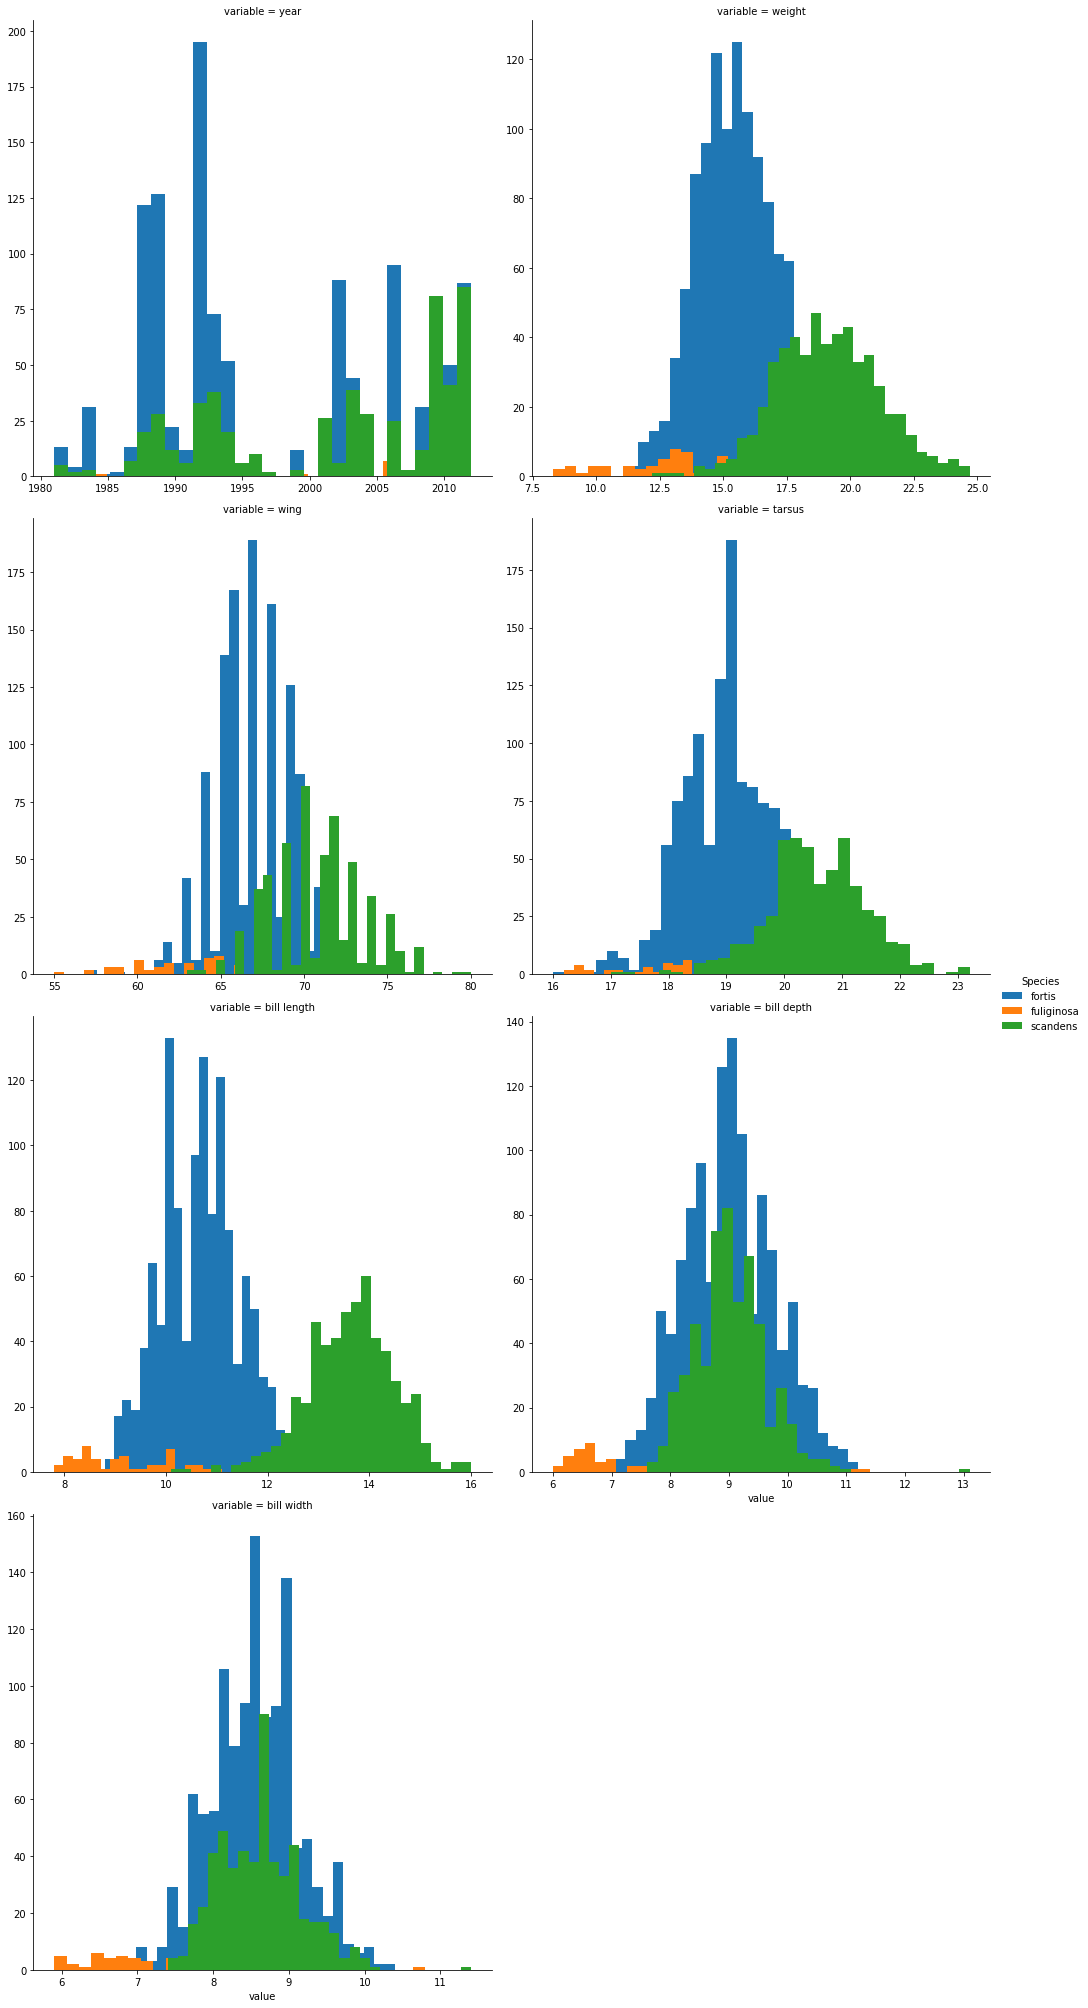

In [34]:
# Investigate the distribution of numeric features in each class
data1_num = data1.drop("sex", axis = 1)
def num_feature_hist(data1_num):
    num_features = list(data1_num)
    num_features = num_features.remove("Species")
    
    import seaborn as sns
    data_melt = pd.melt(data1_num, id_vars="Species", value_vars=num_features)
    g = sns.FacetGrid(data_melt, 
                      col = "variable", 
                      hue = "Species", 
                      col_wrap=2, 
                      sharex=False,
                      sharey = False,
                      height = 7)
    g.map(plt.hist, "value", bins = 30).add_legend()

    plt.show()
num_feature_hist(data1_num)        

We should also remove year because that is not a determinant of which species a sample is expected to be.

In [35]:
data1 = data1.drop("year", axis=1)

In [36]:
# finish up cleaning the data and have a look at the data shape
data1.shape

(1800, 8)

### PCA
We use PCA to first have an idea if the classes are separatable by the PCs of these features. PCA needs input data to be standardized. It would be tricky to use categorical variables in PCA because it is challenging to represent the distance between the examples. Therefore, we remove sex.

In [103]:
# Data preparation
data2 = data1.copy()
data2 = data2.drop("sex", axis = 1)

y_pca = data2["Species"]
X_pca = data2.drop("Species", axis = 1)
# use only bill phenotype
#X_pca = X_pca[["bill length", "bill depth", "bill width"]]
X_pca.shape

(1800, 6)

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_pca_scale = scaler.fit_transform(X_pca)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_fit = pca.fit_transform(X_pca_scale)

In [158]:
# PCA visualization
pca_df = pd.DataFrame(data = pca_fit, columns=["PC1", "PC2", "PC3"])
pca_df["Species"] = y_pca

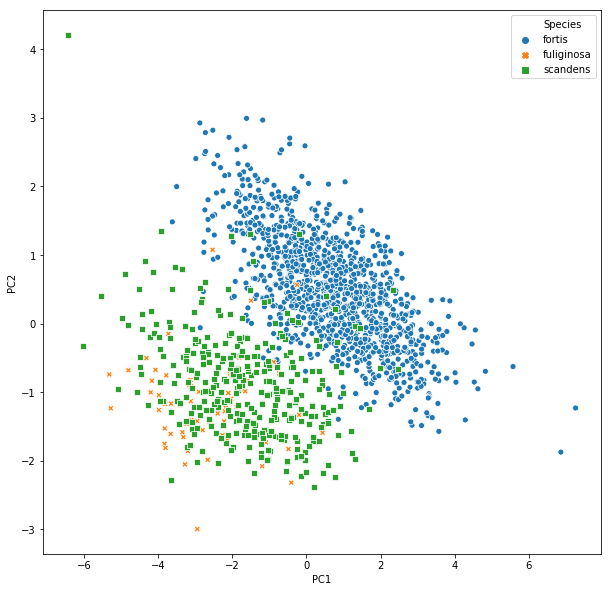

In [146]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = "PC1", y = "PC2", data = pca_df, hue = "Species", style = "Species")
plt.show()

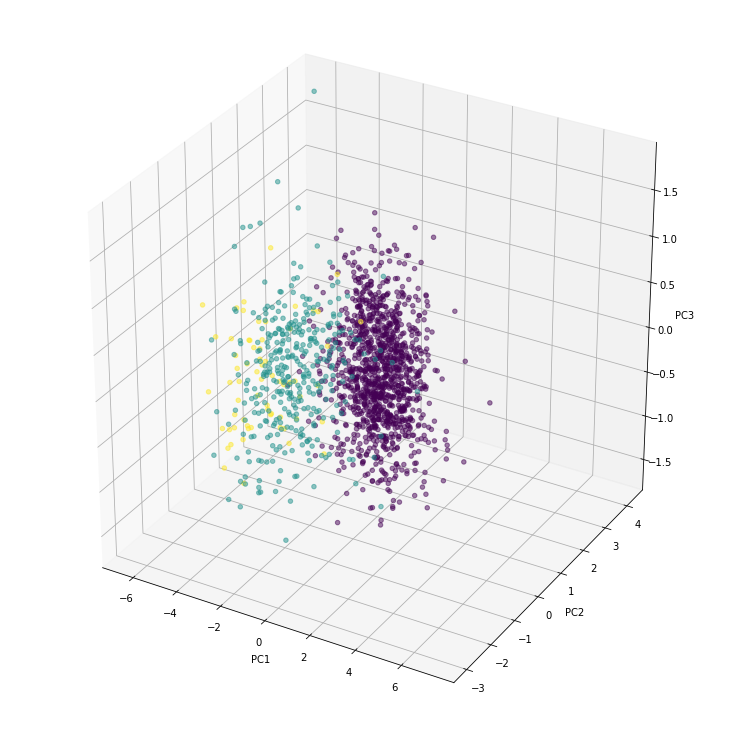

In [166]:
from mpl_toolkits.mplot3d import Axes3D
pca_df["Species"].replace(["fortis", "scandens", "fuliginosa"], [0, 1, 2], inplace=True)

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c=pca_df["Species"], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

## Data preparation

In [37]:
# Always shuffle the data first
shuffled_index = np.random.permutation(data1.index)
data_shuffled = data1.reindex(shuffled_index)

# Separate X and y
X = data_shuffled.drop("Species", axis = 1)
y = data_shuffled["Species"]

# Split the data to traning and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)
print("training data is {} and test data is {}".format(y_train.shape[0], y_test.shape[0]))

training data is 1260 and test data is 540


In [38]:
# Standardize numberic features and OneHotCode for categorical feature
num_features = list(X_train)
num_features.remove("sex")
cat_feature = ["sex"]

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer

pipeline = ColumnTransformer(transformers=[
    ("num", Normalizer(), num_features),
    ("cat", OneHotEncoder(), cat_feature)
])

# Convert X_train
X_train_input = pipeline.fit_transform(X_train)
X_test_input = pipeline.transform(X_test)

## Model selection and learning

### Logistic regression

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_input, y_train)

from sklearn.metrics import accuracy_score
lr_predict = lr.predict(X_test_input)
lr_accuracy = accuracy_score(y_test, lr_predict)
print("Logistic regression: ", lr_accuracy)

Logistic regression:  0.6648148148148149


In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
lr_cm = confusion_matrix(y_test, lr_predict)

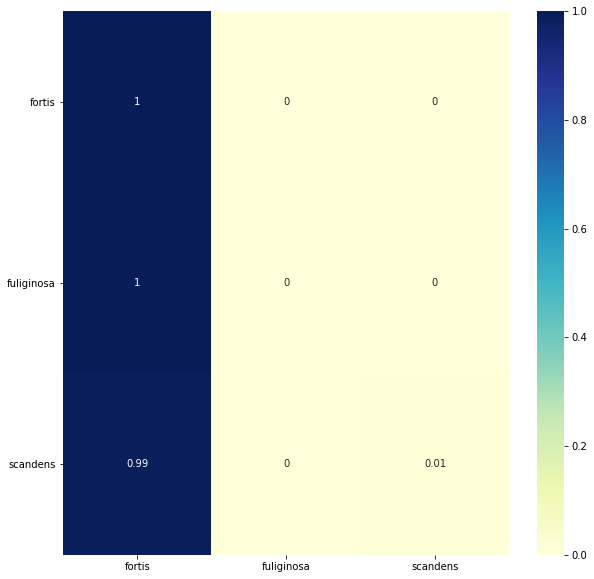

In [41]:
# Visulization of confusion matrix
class_names = list(np.unique(y_train))
def plot_cm(cm, class_names):
    """Normalize confusion matrix and make a heatmap"""
    norm_cm = pd.DataFrame(cm/cm.sum(axis=1, keepdims=True), index = class_names, columns = class_names)
    norm_cm = norm_cm.round(2)
    fig = plt.figure(figsize=(10,10))
    ax = sns.heatmap(norm_cm, annot=True, fmt="g",cmap="YlGnBu")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.show()

plot_cm(lr_cm, class_names)

The Logistic classifier fails the classification: it labels all the examples as fortis.

### Random Forest

In [42]:
# Train
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_input, y_train)

# Prediction
rf_predict = rf.predict(X_test_input)
rf_accuracy = accuracy_score(y_test, rf_predict)
print("Random Forest: ", rf_accuracy)

Random Forest:  0.95


In [68]:
# Model tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_depth": [5, 10, 15],
    "min_samples_leaf":[1, 3],
    "min_samples_split": [2, 3, 5],
    "n_estimators": [100, 200, 300]
}

rf = RandomForestClassifier(random_state=42)
rf_GS = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 3)
rf_GS.fit(X_train_input, y_train)
rf_GS.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [69]:
# Predict again on the best model
rf_best = rf_GS.best_estimator_
rf_best_predict = rf_best.predict(X_test_input)
rf_best_accuracy = accuracy_score(y_test, rf_best_predict)
print("Random Forest best estimator: ", rf_best_accuracy)

Random Forest best estimator:  0.95


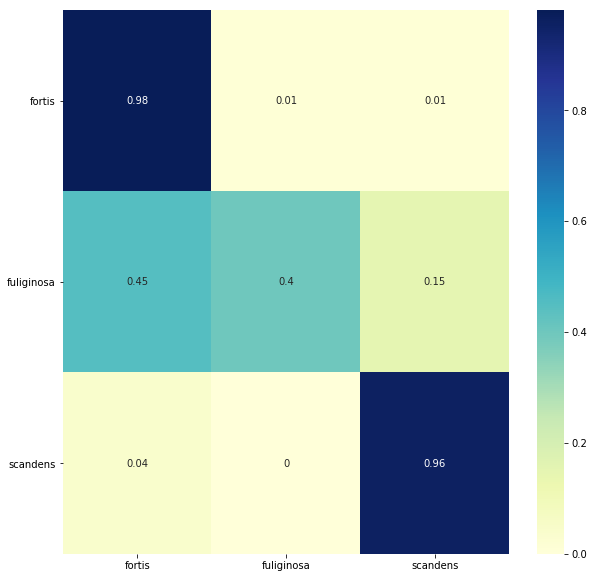

In [70]:
# confusion matrix
rf_best_cm = confusion_matrix(y_test, rf_best_predict)
plot_cm(rf_best_cm, class_names)

Although the accuracy is certainly incereased, this is still a very poor classification because it can only well characterize fortis and scandens, which account for most examples. The majority of the other classes, including pure fuliginosa, is incorrectly placed.

In [71]:
# Inverstigate feature importance
rf_feature_impor = pd.DataFrame({"Importance":list(rf_best.feature_importances_), 
                                 "Features": list(X_train.drop("sex", axis=1)) + ["female", "male", "unknown"]})

rf_feature_impor.sort_values(["Importance"])

,Importance,Features
6,0.002164,female
7,0.002496,male
8,0.004442,unknown
2,0.029681,tarsus
5,0.096224,bill width
0,0.104370,weight
4,0.107823,bill depth
1,0.151095,wing
3,0.501704,bill length


### Support Vector Machine

In [47]:
from sklearn.svm import SVC
svc = SVC(random_state=42)
svc.fit(X_train_input, y_train)

svc_predict = svc.predict(X_test_input)
svc_accuracy = accuracy_score(y_test, svc_predict)
print("SVC:", svc_accuracy)

SVC: 0.662962962962963


In [64]:
# Tune hyperparameters
param_grid = {
    "gamma": [300, 500, 700],
    "C": [1, 10, 50]
}

svc = SVC(random_state=42)
svc_GS = GridSearchCV(svc, param_grid=param_grid, cv = 3)
svc_GS.fit(X_train_input, y_train)
svc_GS.best_params_

{'C': 10, 'gamma': 500}

In [65]:
svc_best = svc_GS.best_estimator_
svc_best_predict = svc_best.predict(X_test_input)
svc_best_accuracy = accuracy_score(y_test, svc_best_predict)
print("SVC best: ", svc_best_accuracy)

SVC best:  0.95


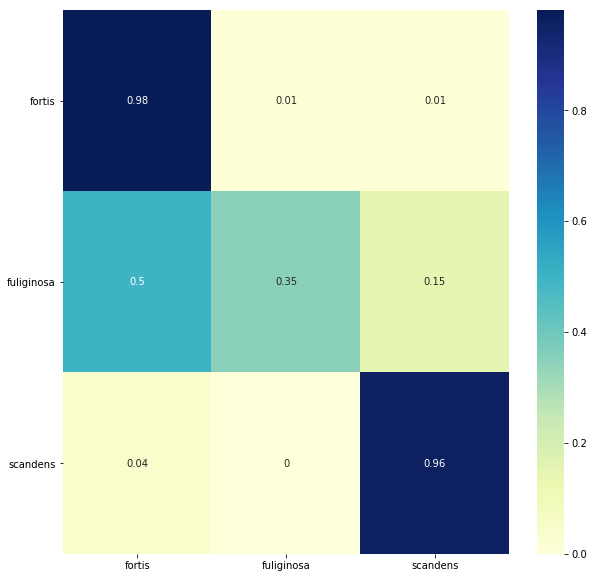

In [72]:
# confusion matrix
svc_best_cm = confusion_matrix(y_test, svc_best_predict)
plot_cm(svc_best_cm, class_names)

No improvement observed in SVC model.

### Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_input, y_train)

gnb_predict = gnb.predict(X_test_input)
gnb_accuracy = accuracy_score(y_test, gnb_predict)
print("Naive Bayes:", gnb_accuracy)

Naive Bayes: 0.9148148148148149


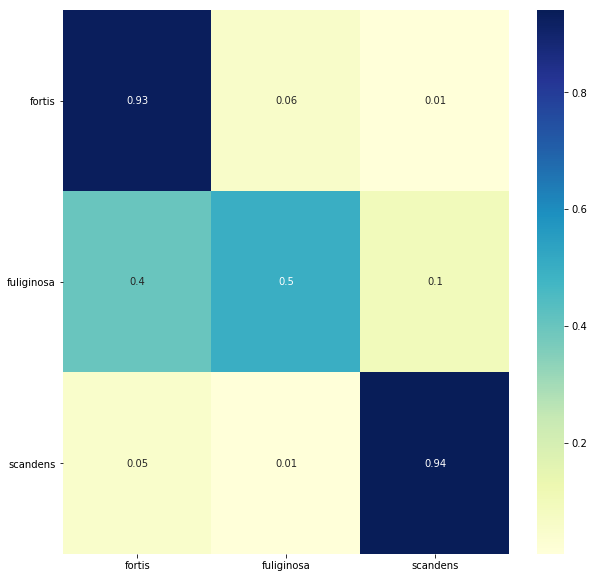

In [52]:
# confusion matrix
gnb_cm = confusion_matrix(y_test, gnb_predict)
plot_cm(gnb_cm, class_names)

Because Naive Bayes is only dependent on priors which means there is no need to tune or there is no hyperparameters to tune. This model still does not improve so much, but it shows a better classification of fuliginosa than the other models.

### K-nearest neighbors

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_input, y_train)

knn_predict = knn.predict(X_test_input)
knn_accuracy = accuracy_score(y_test, knn_predict)
print("KNN: ", knn_accuracy)

KNN:  0.9518518518518518


In [54]:
# Tune hyperparameters
param_grid = {
    "n_neighbors": [5, 10, 20, 30],
}

knn = KNeighborsClassifier()
knn_GS = GridSearchCV(knn, param_grid=param_grid, cv = 3)
knn_GS.fit(X_train_input, y_train)
knn_GS.best_params_

{'n_neighbors': 5}

In [55]:
knn_best = knn_GS.best_estimator_
knn_best_predict = knn_GS.predict(X_test_input)
knn_best_accuracy = accuracy_score(y_test, knn_best_predict)
print("KNN best: ", knn_best_accuracy)

KNN best:  0.9518518518518518


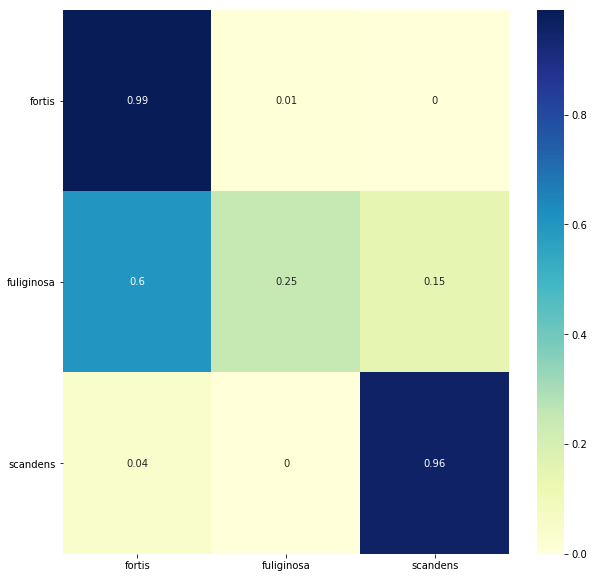

In [56]:
# confusion matrix
knn_best_cm = confusion_matrix(y_test, knn_best_predict)
plot_cm(knn_best_cm, class_names)

### MLP Neural Network

In [57]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_input, y_train)

mlp_predict = mlp.predict(X_test_input)
mlp_accuracy = accuracy_score(y_test, mlp_predict)
print("MLP NN: ", mlp_accuracy)

MLP NN:  0.9259259259259259


In [58]:
# Tune hyperparameters
param_grid = {
    "solver": ["lbfgs"],
    "max_iter": [400, 600, 1000],
    "batch_size": [600, 1000],
    "activation": ["identity", "logistic", "tanh", "relu"]
}

mlp = MLPClassifier(random_state=42)
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, cv = 3)
mlp_GS.fit(X_train_input, y_train)
mlp_GS.best_params_

{'activation': 'identity',
 'batch_size': 600,
 'max_iter': 600,
 'solver': 'lbfgs'}

In [59]:
mlp_best = mlp_GS.best_estimator_
mlp_best_predict = mlp_GS.predict(X_test_input)
mlp_best_accuracy = accuracy_score(y_test, mlp_best_predict)
print("MLP NN best: ", mlp_best_accuracy)

MLP NN best:  0.95


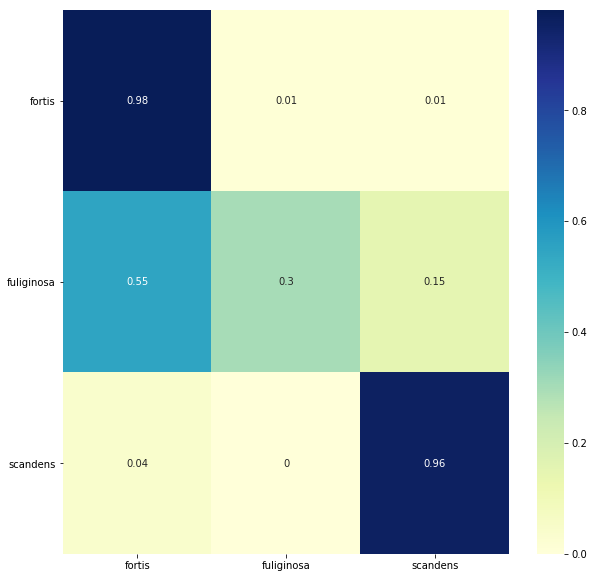

In [60]:
# Confusion matrix
mlp_best_cm = confusion_matrix(y_test, mlp_best_predict)
plot_cm(mlp_best_cm, class_names)

Even with neural network, the classification only has good performance for pure scandens and fortis.

## Model comparisons

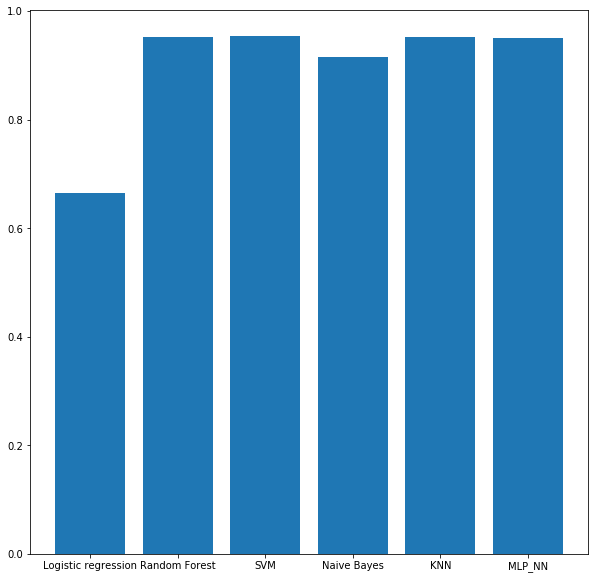

In [61]:
models = ["Logistic regression","Random Forest", "SVM", "Naive Bayes", "KNN", "MLP_NN"]
accuracies = [lr_accuracy, rf_best_accuracy, svc_best_accuracy, gnb_accuracy, knn_best_accuracy, mlp_best_accuracy]

fig = plt.figure(figsize=(10, 10))
plt.bar(models, accuracies)
plt.show()

## Conclusion
1. Except logistic regression, all the other models could reach accuracy above 90%. However, they are only able to make a fairly good classification on fortis and scandens. fuliginosa cannot be well classfied.  
2. The three most importance features are bill length, wing and bill depth. Sex doesn't seem to play a key role in determining the class.  
